# Introduction
To High Dimensional Monte Carlo Density Estimation

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

np.random.seed(0)

In [2]:
plt.style.use("illumina.mplstyle")

## Preprocessing

Load dataset. The Iris data set is used as it is not overly complex.

In [3]:
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df["species"] = pd.Categorical.from_codes(iris.target, iris.target_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Remove setosa flowers as am only interested in true or false

In [4]:
df = df[df["species"] != "setosa"]
species = df["species"]

Drop species as it is the target.

In [5]:
df = df.drop(["species"], axis=1)

Rename columns as they are annoyingly long.

In [6]:
df.columns = ["s" + str(i) for i, _ in enumerate(df.columns)]

Scale the data (this is essential given the proposed model).
TODO: Change sclaing function to negate sparsity of data, saving the transform function.

In [7]:
df = df.select_dtypes(include=np.number)
scaled = pd.DataFrame(MinMaxScaler().fit_transform(df))
scaled.columns = df.columns
scaled.head()

,s0,s1,s2,s3
0,0.700000,0.666667,0.435897,0.266667
1,0.500000,0.666667,0.384615,0.333333
2,0.666667,0.611111,0.487179,0.333333
3,0.200000,0.166667,0.256410,0.200000
4,0.533333,0.444444,0.410256,0.333333


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117355b50>,
      dtype=object)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


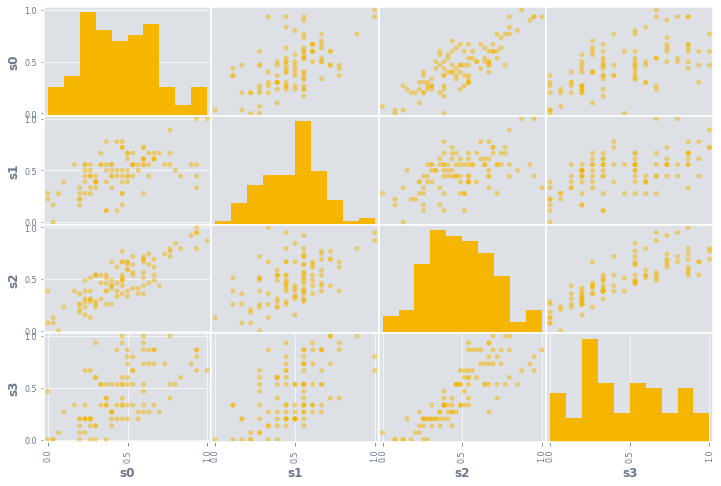

In [8]:
pd.plotting.scatter_matrix(scaled)

Split into test and train

In [9]:
X_train, X_test, y_train, y_test = train_test_split(scaled, np.array(species), test_size=0.33, random_state=42)

## Classifier Training
and prediction

In [10]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [11]:
print(clf.feature_importances_)

[0.07650935 0.020033   0.5463284  0.35712925]


In [12]:
preds = clf.predict(X_test)
certs = clf.predict_proba(X_test)

In [13]:
confusion = [tn, fp, fn, tp] = confusion_matrix(preds, y_test).ravel()
tn, fp, fn, tp = [i/len(preds) * 100 for i in confusion]
print("Results separated for inspection.")
print("+-------+----------+----------+")
print("|       | Positive | Negative |")
print("+-------+----------+----------+")
print("| True  | {:7.3f}% | {:7.3f}% |".format(tp, tn))
print("+-------+----------+----------+")
print("| False | {:7.3f}% | {:7.3f}% |".format(fp, fn))
print("+-------+----------+----------+")

Results separated for inspection.
+-------+----------+----------+
|       | Positive | Negative |
+-------+----------+----------+
| True  |  30.303% |  54.545% |
+-------+----------+----------+
| False |  12.121% |   3.030% |
+-------+----------+----------+


## Naive Monte Carlo Integration

The key equation for this estimation of density is:

$$ I = \{ \frac{1}{n} \sum^n_{i=1} f(x_i, \frac{q}{y}) \}^y_{q=0} $$

where 

* $I$ is the dimension the kernel density is being estimated of.

* $n$ is the number of samples taken.

* $f$ is the density function.

* $x$ are randomly selected values from the function, excluding $y$.

* $y$ is the resolution of $I$ (number of samples, equally spaced).

In [14]:
def naive_mc_integrate(df, column, clf, n=100, Y=np.linspace(0, 1, 11), v=True):
    y_column = column  # The dimension to estimate kde of.
    y_index = df.columns.get_loc(y_column)  # The index of that dimension.
    f = lambda x: clf.predict_proba([x])[0][1]
    d = df.shape[1] # Number of dimensions.
    
    I = []
    for q in Y:
        q_val = []
        for i in range(n):
            # Draw random sample from the sample space.
            D = np.random.uniform(0, 1, d)
            D[y_index] = q

            # Append the density of the prediction at a point.
            prediction = f(D)
            q_val.append(prediction)

        q_val = sum(q_val) / n
        I.append(q_val)
        
    I = np.array(I)
    if v:
        print("Integration complete for", column)
    return I

In [15]:
y_vals = np.linspace(0, 1, 31)
s0_kde = naive_mc_integrate(df, "s0", clf, Y=y_vals)
s1_kde = naive_mc_integrate(df, "s1", clf, Y=y_vals)
s2_kde = naive_mc_integrate(df, "s2", clf, Y=y_vals)
s3_kde = naive_mc_integrate(df, "s3", clf, Y=y_vals)

### 1D KDE Visualization

In [16]:
viz_df = pd.DataFrame({"s0_kde": s0_kde-0.5,
                       "s1_kde": s1_kde-0.5,
                       "s2_kde": s2_kde-0.5,
                       "s3_kde": s3_kde-0.5,
                       "Position": np.round(y_vals, 2)})

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


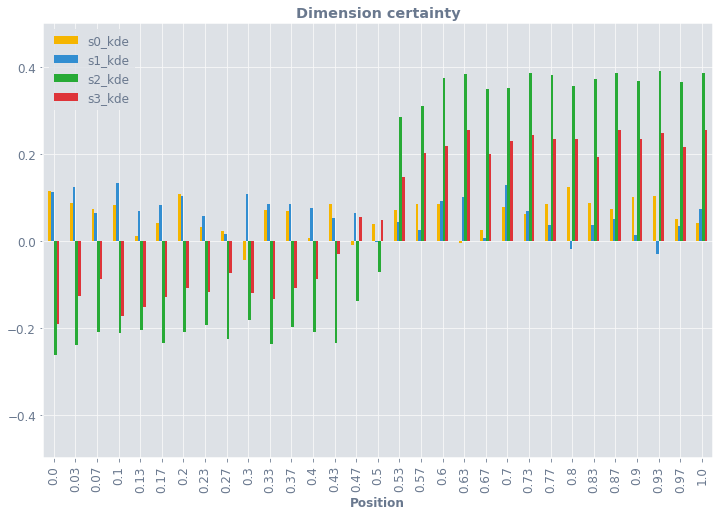

In [17]:
viz_df.plot.bar(ylim=(-0.5, 0.5), x="Position", title="Dimension certainty")

### 2D KDE Visualization

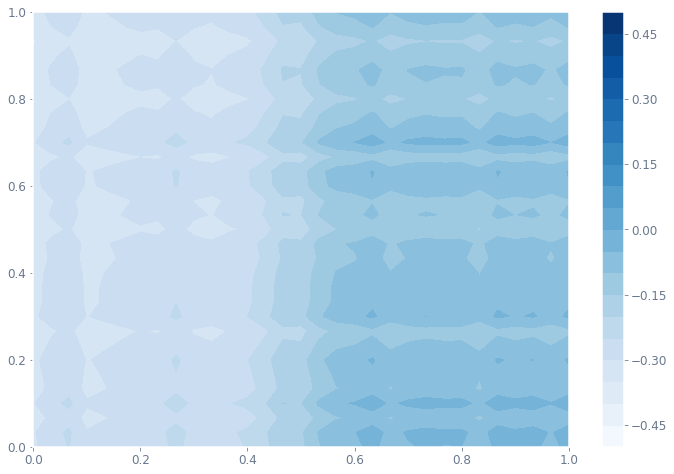

In [18]:
Xm, Ym = np.meshgrid(y_vals, y_vals)
Zm = [[(i*j)-0.5 for i in s3_kde] for j in s1_kde]
contours = plt.contourf(Xm, Ym, Zm, levels=np.linspace(-0.5, 0.5, 21))
# plt.clabel(contours, inline=True)
plt.colorbar();

## VEGAS Monte Carlo Integration

### Density Estimation
By taking samples from the area with the most samples, a much more accurate interpretation can be made

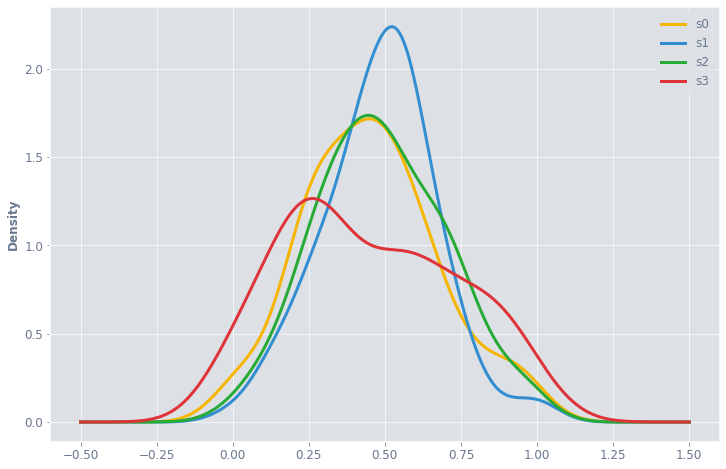

In [19]:
scaled.plot.density()

In [51]:
ker = KernelDensity(0.1).fit(scaled)

In [52]:
D = pd.DataFrame(ker.sample(100))

In [54]:
tmp = pd.DataFrame(D)

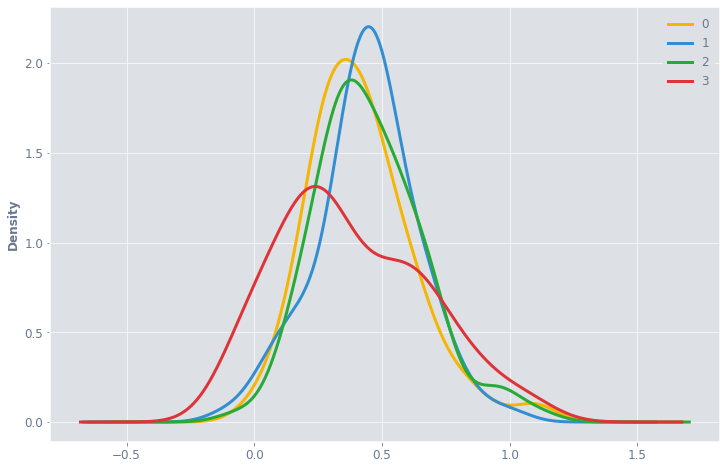

In [56]:
tmp.plot.density()

### Sample Retrieval

The key equation for this estimation of density is:

$$ I = \{ \frac{1}{n} \sum^n_{i=1} f(x_i) \}^y_{q=0} $$

where 

* $I$ is the dimension the kernel density is being estimated of.

* $n$ is the number of samples taken.

* $f$ is the density function.

* $x$ are randomly selected samples according to the density of the total sample space.

* $y$ is the resolution of $I$ (number of samples, spaced randomly according to kernel density of that axis).

In [132]:
def vegas_mc_integrate(df, column, f, n=100, v=True):
    kernel = KernelDensity(0.1).fit(df)
    y_column = column  # The dimension to estimate kde of.
    y_index = df.columns.get_loc(y_column)  # The index of that dimension.
    d = df.shape[1] # Number of dimensions.
    
    # Draw random sample from the sample space.
    D = pd.DataFrame(kernel.sample(n))
    D.columns = df.columns

    # Append the density of the prediction at a point.
    prediction = f(D)
    
    # Select only second index of prediction pairs.
    prediction = np.array([i[1] for i in prediction])
    
    D["prediction"] = prediction
    return D

In [279]:
D = vegas_mc_integrate(scaled, "s2", clf.predict_proba, n=10)

Text(0.5, 1.0, 's2 value and certainty classification')

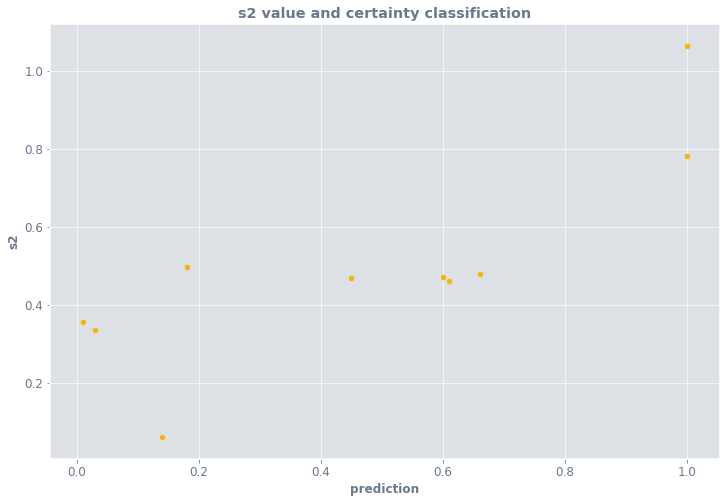

In [280]:
D.plot.scatter(x="prediction", y="s2")
plt.title("s2 value and certainty classification")

### Contour from Binning
I couldnt find a scipy/scikit way of doing this.

First calculate the resolution of the bins

In [281]:
resolution = 26
res_vals = np.linspace(-1.25, 1.25, resolution)
print(res_vals)

[-1.25 -1.15 -1.05 -0.95 -0.85 -0.75 -0.65 -0.55 -0.45 -0.35 -0.25 -0.15
 -0.05  0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95  1.05
  1.15  1.25]


In [282]:
D_bins = {col: }

Iterate through each column and put values into their respective bins.

In [306]:
D_bins = {}
for col in D.columns[:-1]:
    col_num = D.columns.get_loc(col)
    D = D.sort_values(by=[col])
    bin_vals = [[] for _, _ in enumerate(res_vals)]
    for row in D.iterrows():
        row = row[1]  # Not interested in value of index.
        bin_index = 0
        while row[col_num] > res_vals[bin_index]:
            bin_index += 1
        bin_vals[bin_index].append(row["prediction"])
    bin_vals = [0.5 if np.isnan(np.mean(i)) else np.mean(i) for i in bin_vals]
    D_bins[col] = [np.nanmean(i) for i in bin_vals]
    print(col, "complete")
print(D_bins)

s0 complete
s1 complete
s2 complete
s3 complete
{'s0': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.14, 0.5, 0.03, 0.63, 0.61, 0.23, 0.18, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5], 's1': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.01, 0.5433333333333333, 0.8049999999999999, 0.16, 0.5, 0.66, 0.45, 0.5, 0.5, 0.5, 0.5, 0.5], 's2': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.14, 0.5, 0.03, 0.01, 0.5000000000000001, 0.5, 0.5, 1.0, 0.5, 0.5, 1.0, 0.5], 's3': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.085, 0.01, 0.5, 0.5, 0.18, 0.5, 0.5, 0.7366666666666667, 0.5, 0.555, 1.0, 0.5, 0.5, 0.5]}


### 1D KDE Visualization

In [16]:
viz_df = pd.DataFrame({"s0_kde": s0_kde-0.5,
                       "s1_kde": s1_kde-0.5,
                       "s2_kde": s2_kde-0.5,
                       "s3_kde": s3_kde-0.5,
                       "Position": np.round(y_vals, 2)})

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


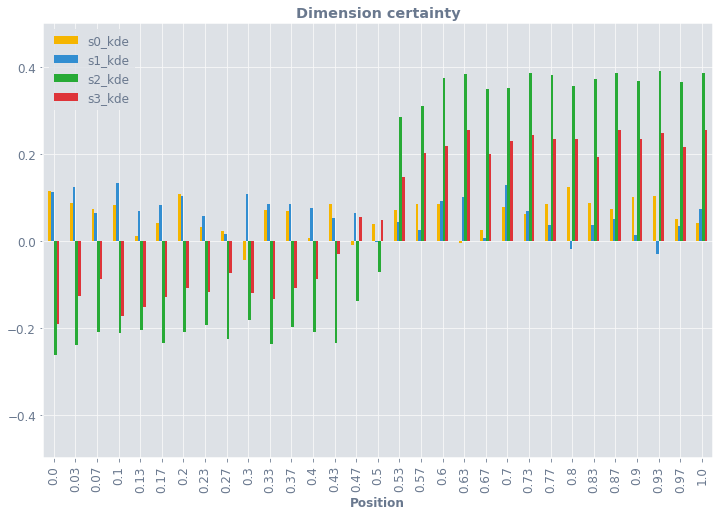

In [17]:
viz_df.plot.bar(ylim=(-0.5, 0.5), x="Position", title="Dimension certainty")